In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import get_scheduler, AutoTokenizer, create_optimizer
from transformers import DataCollatorForTokenClassification
from transformers import TFAutoModelForTokenClassification
from datasets import load_dataset

from tqdm import tqdm

pd.set_option('display.max_columns', None)

In [2]:
is_gpu = tf.test.is_gpu_available()
is_gpu

2023-01-22 12:27:19.841728: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 12:27:19.904695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:27:19.905761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:27:19.906447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

True

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

if not is_gpu:
    set_seed()
else:
    print("Non-deterministic learning.")

Non-deterministic learning.


In [4]:
data = pd.read_csv("/kaggle/input/entity-annotated-corpus/ner_dataset.csv", encoding="unicode-escape").fillna(method="ffill")
tags = data["Tag"].unique()
data = data.rename(columns={"Sentence #": "sent_id"})
data = data.groupby("sent_id").agg(lambda x: list(x)).reset_index(drop=True)

data.head()

,Word,POS,Tag
0,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
3,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]"
4,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."


count    47959.000000
mean        21.863988
std          7.963680
min          1.000000
25%         16.000000
50%         21.000000
75%         27.000000
max        104.000000
Name: Word, dtype: float64

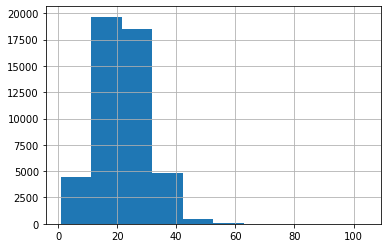

In [5]:
data["Word"].apply(len).hist()
data["Word"].apply(len).describe()

In [41]:
X = data["Word"].apply(lambda x: ' '.join(x))

In [42]:
max_length = 100
vocab_size = 35500
num_tags = len(tags)

tokenizer = Tokenizer(lower=False, filters="", num_words=vocab_size)
tokenizer.fit_on_texts(X)
print(f"Vocabulary size: {len(tokenizer.word_index)}")

encoded_sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(encoded_sequences, maxlen=max_length, padding="post")

Vocabulary size: 35178


In [43]:
for idx, tag, word in zip(X[0].tolist(), data["Tag"][0], data["Word"][0]):
    print(idx, " = ", tag, ": ", word)

1114  =  O :  Thousands
4  =  O :  of
1161  =  O :  demonstrators
16  =  O :  have
1852  =  O :  marched
229  =  O :  through
478  =  B-geo :  London
6  =  O :  to
533  =  O :  protest
1  =  O :  the
155  =  O :  war
5  =  O :  in
58  =  B-geo :  Iraq
8  =  O :  and
582  =  O :  demand
1  =  O :  the
843  =  O :  withdrawal
4  =  O :  of
179  =  B-gpe :  British
87  =  O :  troops
21  =  O :  from
15  =  O :  that
52  =  O :  country
2  =  O :  .


In [44]:
word2id = tokenizer.word_index
id2word = {v: k for k, v in word2id.items()}

In [45]:
tags2id = {}
for i, tag in enumerate(tags):
    tags2id[tag] = i
    
id2tags = {v: k for k, v in tags2id.items()}

In [46]:
def preprocess_tags(tags2id, tag_sequences, maxlen=max_length):
    final_encoded_tags = []
    for list_tags in tag_sequences:
        encoded_tags = []
        for tag in list_tags:
            encoded_tags.append(tags2id[tag])
        current_length = len(encoded_tags)
        if current_length > maxlen:
            encoded_tags = encoded_tags[:maxlen]
        else:
            padding_size = maxlen - current_length
            padding = [tags2id["O"]] * padding_size
            encoded_tags = encoded_tags + padding
        final_encoded_tags.append(encoded_tags)
        
    return final_encoded_tags 

In [47]:
y = preprocess_tags(tags2id, data["Tag"].values)
# y = [keras.utils.to_categorical(i, num_classes=num_tags) for i in y]  # use categorical_crossentropy

In [48]:
X, y = np.asarray(X), np.asarray(y)

In [49]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=10000, shuffle=True, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=2000, shuffle=True, random_state=42)

print(f"Train size: {len(y_train)}, validation size: {len(y_valid)}, test size: {len(y_test)}")

Train size: 37959, validation size: 8000, test size: 2000


In [50]:
def prepare_dataset(x, y, batch_size=128, cache=True, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if cache:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(x))
    ds = ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [51]:
train_ds = prepare_dataset(x_train, y_train, batch_size=32)
valid_ds = prepare_dataset(x_valid, y_valid, batch_size=32, cache=False, shuffle=False)
test_ds = prepare_dataset(x_test, y_test, batch_size=32, cache=False, shuffle=False)

In [62]:
embedding_dim = 128
vocab_size = len(tokenizer.word_index)+1

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, mask_zero=False),
    layers.Bidirectional(layers.LSTM(units=128, return_sequences=True)),
    # layers.Bidirectional(layers.LSTM(units=128, return_sequences=True)),
    layers.SpatialDropout1D(rate=0.3),
    layers.TimeDistributed(layers.Dense(units=num_tags, activation="softmax"))
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         4502912   
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, None, 256)         0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 17)          4369      
Total params: 4,770,449
Trainable params: 4,770,449
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [keras.callbacks.ReduceLROnPlateau(verbose=1, patience=2),
             keras.callbacks.EarlyStopping(patience=5, verbose=1, restore_best_weights=True)]

In [64]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=16, callbacks=callbacks)

Epoch 1/16
1187/1187 [==============================] - 20s 15ms/step - loss: 0.0857 - accuracy: 0.9810 - val_loss: 0.0296 - val_accuracy: 0.9914
Epoch 2/16
1187/1187 [==============================] - 17s 14ms/step - loss: 0.0236 - accuracy: 0.9930 - val_loss: 0.0243 - val_accuracy: 0.9927
Epoch 3/16
1187/1187 [==============================] - 17s 15ms/step - loss: 0.0173 - accuracy: 0.9946 - val_loss: 0.0239 - val_accuracy: 0.9928
Epoch 4/16
1187/1187 [==============================] - 17s 15ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 0.0242 - val_accuracy: 0.9929
Epoch 5/16
1187/1187 [==============================] - 17s 14ms/step - loss: 0.0121 - accuracy: 0.9961 - val_loss: 0.0254 - val_accuracy: 0.9928

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/16
1187/1187 [==============================] - 17s 15ms/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.0258 - val_accuracy: 0.9930
Epoch 7/16
1187/1187 [====================

In [65]:
model.evaluate(train_ds)

1187/1187 [==============================] - 7s 6ms/step - loss: 0.0127 - accuracy: 0.9960


[0.012668955139815807, 0.9959927797317505]

In [57]:
def make_random_prediction(x, model, id2word, id2tag, y=None, return_raw=False):
    idx = np.random.randint(x.shape[0])
    
    encoded_sample = x[idx]
    encoded_sample = np.array(encoded_sample)
    if y is not None and np.all(y[idx] == 0):
        return make_random_prediction(x, model, id2word, id2tag, y)
    
    original_sample = [id2word[int(token)] for token in encoded_sample[encoded_sample>0]]
    original_length = len(original_sample)
    original_sample = " ".join(original_sample)
    
    encoded_sample = encoded_sample.reshape((1, -1))
    prediction = model.predict(encoded_sample)
    prediction = np.argmax(prediction[0], axis=-1)
    
    prediction = prediction[:original_length]
    prediction = " ".join([id2tag[token] for token in prediction])
    
    if y is None:
        return original_sample, prediction
    else:
        original_tags = " ".join([id2tag[token] for token in y[idx][:original_length]])
        if not return_raw:
            results = pd.DataFrame({"Sentence": original_sample.split(), "Tags": original_tags.split(), "Predictions": prediction.split()}).transpose()
            return results
        return original_sample, prediction, original_tags

In [58]:
for i in range(10):
    # original_sample, prediction, original_tags = make_random_prediction(x_test, model, id2word, id2tags, y_test, return_raw=True)
    results = make_random_prediction(x_test, model, id2word, id2tags, y_test, return_raw=False)
    print(f"Random sample {i+1}")
    display(results)

Random sample 1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Sentence,In,other,violence,",",the,U.S.,military,in,Iraq,says,two,American,soldiers,were,killed,in,separate,incidents,.
Tags,O,O,O,O,O,B-geo,O,O,B-geo,O,O,B-gpe,O,O,O,O,O,O,O
Predictions,O,O,O,O,O,B-geo,O,O,B-geo,O,O,B-gpe,O,O,O,O,O,O,O


Random sample 2


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Sentence,Mohammad,Ashraful,led,the,visitors,with,70,runs,",",including,10,fours,and,one,six,on,the,short,boundaries,of,the,Eden,Park,ground,.
Tags,B-per,I-per,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O,O
Predictions,B-per,I-per,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-org,I-org,O,O


Random sample 3


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
Sentence,In,accepting,the,prize,for,himself,and,his,organization,",",Mr.,ElBaradei,noted,that,15,years,after,the,end,of,the,Cold,War,removed,divisions,in,Europe,",",the,divisions,between,rich,and,poor,countries,still,remain,.
Tags,O,O,O,O,O,O,O,O,O,O,B-per,I-per,O,O,B-tim,O,O,O,B-tim,I-tim,O,B-tim,I-tim,O,O,O,B-geo,O,O,O,O,O,O,O,O,O,O,O
Predictions,O,O,O,O,O,O,O,O,O,O,B-per,I-per,O,O,O,O,O,O,B-tim,O,O,O,O,O,O,O,B-geo,O,O,O,O,O,O,O,O,O,O,O


Random sample 4


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Sentence,The,tally,beats,the,previous,record,of,$,135.6,million,",",set,last,summer,by,Pirates,Of,The,Caribbean,:,Dead,Man,'s,Chest,.
Tags,O,O,O,O,O,O,O,O,O,O,O,O,O,B-tim,O,B-org,O,O,B-geo,O,O,O,O,O,O
Predictions,O,O,O,O,O,O,O,O,O,O,O,O,O,B-tim,O,O,O,O,B-geo,O,O,O,O,O,O


Random sample 5


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Sentence,Thousands,of,Sri,Lankans,observed,a,minute,of,silence,",",and,the,Tamil,Tiger,rebels,declared,a,day,of,mourning,.
Tags,O,O,B-gpe,I-gpe,O,O,O,O,O,O,O,O,B-org,I-org,O,O,O,O,O,O,O
Predictions,O,O,B-geo,I-geo,O,O,O,O,O,O,O,O,B-org,I-org,O,O,O,O,O,O,O


Random sample 6


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Sentence,The,usually,balmy,town,near,the,Gulf,of,Mexico,was,hit,with,an,unprecedented,30,centimeters,of,snow,overnight,.
Tags,O,O,O,O,O,O,B-geo,I-geo,I-geo,O,O,O,O,O,O,O,O,O,O,O
Predictions,O,O,O,O,O,O,B-geo,I-geo,I-geo,O,O,O,O,O,O,O,O,O,B-tim,O


Random sample 7


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Sentence,Thursday,",",a,Minsk,court,sentenced,Vintsuk,Vyachorka,",",leader,of,the,Belarus,Popular,Front,",",for,taking,part,in,what,it,called,an,unsanctioned,demonstration,.
Tags,B-tim,O,O,B-org,O,O,B-per,I-per,O,O,O,O,B-org,I-org,I-org,O,O,O,O,O,O,O,O,O,O,O,O
Predictions,B-tim,O,O,B-geo,O,O,B-org,I-org,O,O,O,O,B-org,I-org,I-org,O,O,O,O,O,O,O,O,O,O,O,O


Random sample 8


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Sentence,The,police,chief,says,three,of,the,20,Taleban,fighters,',bodies,were,found,.
Tags,O,O,O,O,O,O,O,O,B-org,O,O,O,O,O,O
Predictions,O,O,O,O,O,O,O,O,B-org,O,O,O,O,O,O


Random sample 9


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
Sentence,The,U.S.,military,",",which,announced,the,arrests,Saturday,",",said,Marines,had,captured,the,two,cell,leaders,during,raids,in,the,city,of,Ramadi,earlier,this,month,.
Tags,O,B-geo,O,O,O,O,O,O,B-tim,O,O,B-org,O,O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,O,O
Predictions,O,B-geo,O,O,O,O,O,O,B-tim,O,O,B-org,O,O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,O,O


Random sample 10


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Sentence,The,Russian,leader,said,Iran,'s,president,told,him,he,wanted,continued,negotiations,with,Britain,",",France,and,Germany,.
Tags,O,B-gpe,O,O,B-geo,O,O,O,O,O,O,O,O,O,B-geo,O,B-geo,O,B-geo,O
Predictions,O,B-gpe,O,O,B-geo,O,O,O,O,O,O,O,O,O,B-geo,O,B-geo,O,B-geo,O


## Transformers HF

In [5]:
hf_data = data.copy(deep=True)

In [6]:
tags2ids = {tag: i for i, tag in enumerate(tags)}
ids2tags = {v: k for k, v in tags2ids.items()}

In [7]:
hf_data["Tag"] = hf_data["Tag"].apply(lambda x: [str(tags2ids[i]) for i in x])

In [8]:
# https://huggingface.co/course/chapter7
hf_data["Word"] = hf_data["Word"].apply(lambda x: " ".join(x))
hf_data["Tag"] = hf_data["Tag"].apply(lambda x: " ".join(x))
hf_data.drop(41770, inplace=True)  # bad sequence: throws error during preprocessing, just drop and forget it

train, valid = train_test_split(hf_data.drop("POS", axis=1), test_size=10000, shuffle=True, random_state=42)
valid, test = train_test_split(valid, test_size=2000, shuffle=True, random_state=42)
train.to_csv("train.csv", index=False)
valid.to_csv("valid.csv", index=False)
test.to_csv("test.csv", index=False)

In [55]:
train.head(1)

,Word,Tag
25285,Bulgaria 's center-left government has survive...,1 0 0 0 0 0 0 0 0 0 0 0 0 0 5 6 0 0


In [9]:
dataset = load_dataset(path="csv", data_files={"train": ["train.csv"], "validation": ["valid.csv"], "test": ["test.csv"]})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-6bb5e5f0794dac86/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
model_checkpoint = "bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [11]:
def preprocess_strings(examples):
    examples["Tag"] = [int(i) for i in examples["Tag"].split()]
    examples["Word"] = examples["Word"].split()
    return examples

In [12]:
dataset = dataset.map(preprocess_strings)

  0%|          | 0/37958 [00:00<?, ?ex/s]

  0%|          | 0/8000 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

In [13]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [14]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["Word"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["Tag"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
            
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [15]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

  0%|          | 0/38 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [16]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")

In [17]:
model = TFAutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=ids2tags,
    label2id=tags2ids,
    use_cache=False,
)

2023-01-22 12:28:14.657535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:28:14.658442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:28:14.659117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:28:14.660725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:28:14.661414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    shuffle=False,
    batch_size=8,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_datasets["test"],
    shuffle=False,
    batch_size=8,
    collate_fn=data_collator,
)

In [19]:
num_epochs = 3
total_train_steps = (len(tokenized_datasets["train"]) // 8) * num_epochs
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=0,
    num_train_steps=total_train_steps,
)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [20]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=num_epochs)

2023-01-22 12:28:33.574593: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
4744/4744 [==============================] - 432s 87ms/step - loss: 0.1554 - val_loss: 0.1190
Epoch 2/3
4744/4744 [==============================] - 410s 86ms/step - loss: 0.0944 - val_loss: 0.1084
Epoch 3/3
4744/4744 [==============================] - 413s 87ms/step - loss: 0.0555 - val_loss: 0.1174


In [50]:
def make_random_prediction(x, model, tokenizer, ids2tags, return_raw=False):
    idx = np.random.randint(x.shape[0])
    
    sample = x.iloc[idx, :]
    inputs = sample["Word"].split()
    tags = sample["Tag"].split()
    words = tokenizer(
        [inputs], truncation=True, is_split_into_words=True, return_tensors="tf"
        )
    prediction = model(**words)
    prediction = tf.nn.softmax(prediction.logits, axis=-1).numpy()
    prediction = np.argmax(prediction[0], axis=-1)

    prediction = " ".join([ids2tags[token] for token in prediction[1:-1]])  # remove start and end special tokens
    original_tags = " ".join([ids2tags[int(token)] for token in tags])
    original_length = len(inputs)

    if not return_raw:
        results = pd.DataFrame({"Sentence": inputs, "Tags": original_tags.split(), "Predictions": prediction.split()[:original_length]}).transpose()
        return results
    return original_sample, prediction, original_tags

In [87]:
def make_random_prediction(test, model, ids2tags):
    dataset = test.shuffle(len(test))
    inputs, labels = next(iter(dataset))
    labels = labels.numpy()
    
    predictions = model(**inputs)
    predictions = tf.nn.softmax(predictions.logits, axis=-1).numpy()
    predictions = np.argmax(predictions, axis=-1)

    true_labels = [[ids2tags[l] for l in label if l != -100] for label in labels]
    true_predictions = [
            [ids2tags[p] for (p, l) in zip(prediction, label) if l != -100]
                for prediction, label in zip(predictions, labels)
        ]

    for i in range(len(true_labels)):
        print(f"Sentence {i+1}:")
        display(pd.DataFrame({"Tags": true_labels[i], "Predictions": true_predictions[i]}).transpose())

In [88]:
make_random_prediction(tf_test_set, model, ids2tags)  # perfect

Sentence 1:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Tags,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-tim,O
Predictions,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-tim,O


Sentence 2:


,0,1,2,3,4,5,6,7,8,9,10,11
Tags,O,B-org,O,O,O,O,O,O,O,O,O,O
Predictions,O,B-org,O,O,O,O,O,O,O,O,O,O


Sentence 3:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
Tags,O,B-gpe,O,O,O,O,O,O,O,O,O,O,O,B-per,I-per,I-per,I-per,I-per,I-per,I-per,I-per,I-per,O,B-tim,O,O,O,O,O
Predictions,O,B-gpe,O,O,O,O,O,O,O,O,O,O,O,B-per,I-per,I-per,I-per,I-per,I-per,I-per,I-per,I-per,O,B-tim,O,O,O,O,O


Sentence 4:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Tags,B-tim,O,O,B-org,I-org,O,O,O,O,O,B-gpe,O,O,O,O,O,O,O,O
Predictions,B-tim,O,O,B-geo,I-geo,O,O,O,O,O,B-gpe,O,O,O,O,O,O,O,O


Sentence 5:


,0,1,2,3,4,5,6,7,8,9,10,11,12
Tags,O,O,O,O,O,O,O,O,O,O,B-geo,B-tim,O
Predictions,O,O,O,O,O,O,O,O,O,O,B-geo,B-tim,O


Sentence 6:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
Tags,O,O,O,O,O,B-geo,B-gpe,B-gpe,B-gpe,O,O,B-geo,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
Predictions,O,O,O,O,O,B-geo,B-gpe,B-gpe,B-gpe,O,O,B-geo,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


Sentence 7:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Tags,O,B-gpe,O,O,O,O,O,O,O,O,O,B-per,I-geo,I-geo,I-per,I-per,I-per,O,O,O,O,O,O,O,O,O,O,O,O,O
Predictions,O,B-gpe,O,O,O,O,O,O,O,O,O,B-per,I-geo,I-geo,I-per,I-per,I-per,O,O,O,O,O,O,O,O,O,O,O,O,O


Sentence 8:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
Tags,O,O,O,B-geo,O,O,O,B-gpe,O,O,O,B-geo,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
Predictions,O,O,O,B-geo,O,O,O,B-gpe,O,O,O,B-geo,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
